<a href="https://colab.research.google.com/github/23silicon/FlashAttention/blob/main/FlashAttentionBenchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 5.2 MB/s eta 0:00:00


In [2]:
import torch
import math
import sys
from torch.utils.cpp_extension import load_inline
!rm -rf /root/.cache/torch_extensions/

In [3]:
import torch
from torch.utils.cpp_extension import load_inline

if not torch.cuda.is_available():
    print("Cuda not available")
    exit()

cuda_flash_attention = """#include <cuda_runtime.h>
#include <cuda_fp16.h>
#include <cmath>

#define Br 128 //canonical Q tile height name in FlashAttention paper
#define Bc 16 //canonical K/V tiles height
#define padding 1

__global__ void flash_attention(const half* Q, const half* K, const half* V, half* output,
                                int M, int N, int d, int Tr, int Tc, float scale) {
    int id = blockDim.x * blockIdx.x + threadIdx.x;
    extern __shared__ half sram[];
    int sram_stride = d+padding; //sram padding for resolving memory bank conflicts (again hopefully speeding up the kernel)

    //pointers to the beginning of each tile's allocated region in shared memory
    half* Qtile = sram; //rows 0-Br are for Q tile, height Br
    half* Ktile = &sram[Br * sram_stride]; //rows Br-(Br+Bc) are for K tile, height Bc
    half* Vtile = &sram[(Br + Bc) * sram_stride]; //rows (Br+Bc) to end are for Vtile, height Bc


    //loop 1: load tiles of Q into sram.
    // ***Each thread is responsible for loading 1 full row of Q into its respective tile
    if (id < M) {
        for (int i = 0; i < d; i++) {
            Qtile[threadIdx.x * sram_stride + i] = Q[id * d + i];
        }
    }
    __syncthreads();

    //callocs to 0, fixed size typical max for d_model is 128 and explodes to registers
    float acc[128] = {0.0f}; //O matrix accumulator
    float l = 0.0f; //running denominator sum for softmax
    float m = -1e30f; //starts with a very low number, basically -infinity

    //ENTERING MAIN LOOP: here we stream tiles of K and V
    for (int i = 0; i < Tc; i++) {
        //load K/V
        for (int j = 0; j < d; j++) {
            int tilerow_KV = Bc * i + threadIdx.x;
            if (threadIdx.x < Bc) {
                if (tilerow_KV < N) {
                    Ktile[threadIdx.x * sram_stride + j] = K[tilerow_KV * d + j];
                    Vtile[threadIdx.x * sram_stride + j] = V[tilerow_KV * d + j];
                } else {
                    Ktile[threadIdx.x * sram_stride + j] = __float2half(0.0f);
                    Vtile[threadIdx.x * sram_stride + j] = __float2half(0.0f);
                }
            }
        }
        __syncthreads();

        //Next step: compute dot product of this thread's corresponding Q row and every Ktile row (dim: Bc x d)
        float attention_scores[Bc];
        float blockmax = -1e30f;
        #pragma unroll //compiler hint to unroll cus Bc is known at compile time
        for (int row = 0; row < Bc; row++) {
            int global_K_row = i * Bc + row;
            if (global_K_row < N) {
                float sum = 0.0f;
                for (int col = 0; col < d; col++) {
                    // Convert half to float for math stability
                    float q_val = __half2float(Qtile[threadIdx.x * sram_stride + col]);
                    float k_val = __half2float(Ktile[row * sram_stride + col]);
                    sum += q_val * k_val;
                }
                sum *= scale;
                blockmax = max(blockmax, sum);
                attention_scores[row] = sum;
            } else {
                //check for padded rows to set score to -inf instead of 0 because e^0 is 1, not 0.
                attention_scores[row] = -1e30f;
            }
        }

        //Most technically beefy part of this kernel: online safe softmax

        //part 1: Adjust attention scores by subtracting blockmax from each element, find running sum
        float blocksum = 0.0f;
        for (int j = 0; j < Bc; j++) {
            attention_scores[j] = __expf(attention_scores[j] - blockmax);
            blocksum += attention_scores[j];
        }

        //part 2: calculate new global max and scaling factors
        float newmax = max(m, blockmax);
        float scale_f1 = __expf(m - newmax);
        float scale_fb = __expf(blockmax - newmax);

        m = newmax;
        l = (l * scale_f1) + (blocksum * scale_fb); //apply scaling factors

        //part 3: adjust and update accumulator
        for (int col = 0; col < d; col++) {
            acc[col] *= scale_f1;
        }
        for (int j = 0; j < Bc; j++) {
            float scaled_p = attention_scores[j] * scale_fb;
            for (int col = 0; col < d; col++) {
                float v_val_inner = __half2float(Vtile[j * sram_stride + col]);
                acc[col] += scaled_p * v_val_inner;
            }
        }

        __syncthreads();
    }

    //divide each element by l to complete the softmax and write to output
    if (id < M) { //final matrix is M x d, this block write the entire vector of length d to row @id
        float divL = 1.0f / l; //avoid repeated division
        for (int col = 0; col < d; col++) {
            output[id * d + col] = __float2half(acc[col] * divL);
        }
    }
}

// Q, K, V, output are device pointers
extern "C" void solve_flash(const half* Q, const half* K, const half* V, half* output, int M, int N,
                      int d) {
    int Tr = (M + Br - 1) / Br, Tc = (N + Bc - 1) / Bc; //tile counts
    dim3 threadsPerBlock(Br);
    dim3 blocksPerGrid(Tr);
    //extra sram for strided access, hopefully solving sram bank conflicts
    int sram_size = (Br * (d+padding) + Bc * (d+padding) + Bc * (d+padding)) * sizeof(half); //1 tile of Q, 1 tile of K, 1 tile of V
    float scale = 1.0f / sqrtf(d); //scaling factor multiplied by each element before softmax

    flash_attention<<<blocksPerGrid, threadsPerBlock, sram_size>>>(Q, K, V, output, M, N, d, Tr, Tc, scale);
}"""

cuda_self_attention = """#include <cuda_runtime.h>
#include <stdio.h>
#include <math.h>
#include <cfloat>

const int TILE_SIZE = 16;

__global__ void matrix_multiplication_kernel(const float* A, const float* B, float* C, int M, int d, int N, const float factor, const bool transposed) {
    const int nx = blockIdx.x * blockDim.x + threadIdx.x;
    const int ny = blockIdx.y * blockDim.y + threadIdx.y;
    if (nx < N && ny < M) {
        int idx = ny * N + nx;
        float sum = 0;
        if (transposed) {
            for (int i = 0; i < d; i++) {
                sum += A[ny * d + i] * B[nx * d + i];
            }
        } else {
            for (int i = 0; i < d; i++) {
                sum += A[ny * d + i] * B[i * N + nx];
            }
        }
        C[idx] = sum * factor;
    }
}

__device__ float atomicMaxFloat(float* address, float val) {
    int* address_as_int = (int*)address;
    int old = *address_as_int, assumed;

    do {
        assumed = old;
        old = atomicCAS(address_as_int, assumed, __float_as_int(fmaxf(val, __int_as_float(assumed))));
    } while (assumed != old);

    return __int_as_float(old);
}

__global__ void row_max_kernel(const float* input, float* row_max, const int M, const int N) {
    const int nx = blockIdx.x * blockDim.x + threadIdx.x;
    const int ny = blockIdx.y * blockDim.y + threadIdx.y;

    const int idx = ny * N + nx;
    const int tid = threadIdx.x;
    const int bid = threadIdx.y;
    __shared__ float sd[TILE_SIZE][TILE_SIZE];
    sd[bid][tid] = (nx < N && ny < M) ? input[idx] : FLT_MIN;
    __syncthreads();

    for (int offset = blockDim.x >> 1; offset > 0; offset >>= 1) {
        if (tid < offset && sd[bid][tid] < sd[bid][tid + offset]) {
            sd[bid][tid] = sd[bid][tid + offset];
        }
        __syncthreads();
    }

    if (tid == 0) {
        atomicMaxFloat(&row_max[ny], sd[bid][0]);
    }
}

__global__ void row_sum_kernel(const float* input, float* row_max, float* row_sum, const int M, const int N) {
    const int nx = blockIdx.x * blockDim.x + threadIdx.x;
    const int ny = blockIdx.y * blockDim.y + threadIdx.y;

    const int idx = ny * N + nx;
    const int tid = threadIdx.x;
    const int bid = threadIdx.y;
    __shared__ float sd[TILE_SIZE][TILE_SIZE];
    sd[bid][tid] = (nx < N && ny < M) ? expf(input[idx] - row_max[ny]) : 0.0;
    __syncthreads();

    for (int offset = blockDim.x >> 1; offset > 0; offset >>= 1) {
        if (tid < offset) {
            sd[bid][tid] += sd[bid][tid + offset];
        }
        __syncthreads();
    }

    if (tid == 0) {
        atomicAdd(&row_sum[ny], sd[bid][0]);
    }
}

__global__ void softmax_kernel(const float* input, float* output, float* row_max, float* row_sum, const int M, const int N) {
    const int nx = blockIdx.x * blockDim.x + threadIdx.x;
    const int ny = blockIdx.y * blockDim.y + threadIdx.y;
    if (nx < N && ny < M) {
        const int idx = ny * N + nx;
        output[idx] = expf(input[idx] - row_max[ny]) / row_sum[ny];
    }
}

void softmax(const float* input, float* output, int M, int N) {
    dim3 threadsPerBlock(TILE_SIZE, TILE_SIZE);
    dim3 blocksPerGrid((N + threadsPerBlock.x - 1) / threadsPerBlock.x,
                       (M + threadsPerBlock.y - 1) / threadsPerBlock.y);

    float *row_max;
    cudaMalloc((void **)&row_max, sizeof(float) * M);
    row_max_kernel<<<blocksPerGrid, threadsPerBlock>>>(input, row_max, M, N);

    float *row_sum;
    cudaMalloc((void **)&row_sum, sizeof(float) * M);
    cudaMemset(row_sum, 0, sizeof(float) * M);
    row_sum_kernel<<<blocksPerGrid, threadsPerBlock>>>(input, row_max, row_sum, M, N);

    softmax_kernel<<<blocksPerGrid, threadsPerBlock>>>(input, output, row_max, row_sum, M, N);
    cudaFree(row_max);
    cudaFree(row_sum);
}

// Q, K, V, output are device pointers
extern "C" void solve_naive(const float* Q, const float* K, const float* V, float* output, int M, int N, int d) {
    const int SIZE = M * N;
    dim3 threadsPerBlock(TILE_SIZE, TILE_SIZE);

    float* qk;
    cudaMalloc((void **)&qk, sizeof(float) * SIZE);
    dim3 blocksPerGrid((N + threadsPerBlock.x - 1) / threadsPerBlock.x,
                       (M + threadsPerBlock.y - 1) / threadsPerBlock.y);
    const float factor = 1 / sqrt((float)d);
    matrix_multiplication_kernel<<<blocksPerGrid, threadsPerBlock>>>(Q, K, qk, M, d, N, factor, true);

    float* softMaxQK;
    cudaMalloc((void **)&softMaxQK, sizeof(float) * SIZE);
    softmax(qk, softMaxQK, M, N);
    cudaFree(qk);

    dim3 blocksPerGrid2((d + threadsPerBlock.x - 1) / threadsPerBlock.x,
                       (M + threadsPerBlock.y - 1) / threadsPerBlock.y);
    matrix_multiplication_kernel<<<blocksPerGrid2, threadsPerBlock>>>(softMaxQK, V, output, M, N, d, 1.0, false);
    cudaFree(softMaxQK);
}"""

cpp_source = """#include <torch/extension.h>

extern "C" void solve_flash(const void* Q, const void* K, const void* V, void* output,
                            int M, int N, int d);

extern "C" void solve_naive(const float* Q, const float* K, const float* V, float* output,
                            int M, int N, int d);

// Wrapper for FlashAttention (Expects FP16 Tensors)
torch::Tensor run_flash(torch::Tensor Q, torch::Tensor K, torch::Tensor V) {
    auto M = Q.size(0);
    auto N = K.size(0);
    auto d = Q.size(1);

    auto output = torch::empty_like(Q);

    solve_flash(
        Q.data_ptr<at::Half>(),
        K.data_ptr<at::Half>(),
        V.data_ptr<at::Half>(),
        output.data_ptr<at::Half>(),
        M, N, d
    );
    return output;
}

// Wrapper for Naive Attention (Expects FP32 Tensors)
torch::Tensor run_naive(torch::Tensor Q, torch::Tensor K, torch::Tensor V) {
    auto M = Q.size(0);
    auto N = K.size(0);
    auto d = Q.size(1);
    auto output = torch::empty_like(Q);

    solve_naive(
        Q.data_ptr<float>(),
        K.data_ptr<float>(),
        V.data_ptr<float>(),
        output.data_ptr<float>(),
        M, N, d
    );
    return output;
}"""

print("Compiling Kernels...")
kernels = load_inline(
    name='comparison_kernels_mixed',
    cpp_sources=cpp_source,
    cuda_sources=cuda_flash_attention + "\n" + cuda_self_attention,
    functions=['run_flash', 'run_naive'],
    extra_cuda_cflags=['-O3', '--use_fast_math', '-arch=sm_75'],
    verbose=True
)
print("Compilation Finished!")

Compiling Kernels...
Compilation Finished!


In [4]:
def profile(func, args, name):
    # Warmup
    for _ in range(3): func(*args)
    torch.cuda.synchronize()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    for _ in range(10):
        func(*args)
    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end) / 10

def pytorch_sdpa(Q, K, V):
    # SDPA expects 4D input: (Batch, Heads, Seq, Dim)
    # We fake Batch=1, Heads=1
    return torch.nn.functional.scaled_dot_product_attention(
        Q.view(1, 1, Q.size(0), Q.size(1)),
        K.view(1, 1, K.size(0), K.size(1)),
        V.view(1, 1, V.size(0), V.size(1))
    ).view(Q.size(0), Q.size(1))

def run_benchmark():
    d = 128
    print(f"\n{'N':<8} | {'Naive (ms)':<15} | {'Flash (ms)':<15} | {'PyTorch (ms)':<15} | {'Speedup'}")
    print("-" * 85)

    naive_times = []
    flash_times = []
    pytorch_times = []

    #Test input sizes N between 2^3 and 2^17 with midpoints between each point (e.g. 12 between 2^3 and 2^4)
    N_values = [x for i in range(2, 17) for x in (2 << i, ((2 << i) + (2 << (i + 1))) // 2)] + [2 << 17]

    for N in N_values:

        # 1. Initialize data as FP16
        Q = torch.randn(N, d, device='cuda', dtype=torch.float16)
        K = torch.randn(N, d, device='cuda', dtype=torch.float16)
        V = torch.randn(N, d, device='cuda', dtype=torch.float16)

        # 2. Naive Benchmark
        t_naive = "OOM"
        try:
            if N <= 32768:
                Q_f, K_f, V_f = Q.float(), K.float(), V.float()
                t_naive = profile(kernels.run_naive, (Q_f, K_f, V_f), "Naive")
                del Q_f, K_f, V_f
            else:
                #NOTE: THIS IS AN OPTIMIZATION SO THAT THE ALGORITHM DOESNT RUN ON BIGGER INPUT SIZES. THE 32768 METRIC WAS THE MEASURED T4 MAX
                t_naive = "OOM (Skipped)"
        except Exception:
            t_naive = "OOM"

        # 3. Flash Benchmark
        try:
            t_flash = profile(kernels.run_flash, (Q,K,V), "Flash")
        except Exception as e:
            t_flash = "Error"
            print(f"Flash Error: {e}")

        # 4. SDPA Benchmark
        try:
            t_sdpa = profile(pytorch_sdpa, (Q,K,V), "SDPA")
        except:
            t_sdpa = "Error"

        # --- DATA COLLECTION LOGIC ---
        # If it's a string (Error/OOM), we store None or float('inf') for plotting

        n_val = t_naive if not isinstance(t_naive, str) else None
        f_val = t_flash if not isinstance(t_flash, str) else None
        p_val = t_sdpa if not isinstance(t_sdpa, str) else None

        naive_times.append(n_val)
        flash_times.append(f_val)
        pytorch_times.append(p_val)

        # Format output for printing
        if isinstance(t_naive, str) or isinstance(t_flash, str):
            speedup = "Inf"
        else:
            speedup = f"{t_naive/t_flash:.2f}x"

        tn_str = f"{t_naive:.4f}" if not isinstance(t_naive, str) else t_naive
        tf_str = f"{t_flash:.4f}" if not isinstance(t_flash, str) else t_flash
        ts_str = f"{t_sdpa:.4f}" if not isinstance(t_sdpa, str) else t_sdpa

        print(f"{N:<8} | {tn_str:<15} | {tf_str:<15} | {ts_str:<15} | {speedup}")

    return N_values, naive_times, flash_times, pytorch_times

input_sizes, naive, flash, pytorch = run_benchmark()


N        | Naive (ms)      | Flash (ms)      | PyTorch (ms)    | Speedup
-------------------------------------------------------------------------------------
8        | 0.2429          | 0.3808          | 0.0328          | 0.64x
12       | 0.2365          | 0.4042          | 0.0317          | 0.59x
16       | 0.2623          | 0.4207          | 0.0309          | 0.62x
24       | 0.2472          | 0.7925          | 0.0300          | 0.31x
32       | 0.2438          | 0.8330          | 0.0313          | 0.29x
48       | 0.2717          | 1.2421          | 0.0340          | 0.22x
64       | 0.2515          | 1.6445          | 0.0297          | 0.15x
96       | 0.2951          | 2.4598          | 0.0370          | 0.12x
128      | 0.3639          | 3.2809          | 0.0297          | 0.11x
192      | 0.5263          | 4.7520          | 0.0301          | 0.11x
256      | 0.4320          | 2.9886          | 0.0294          | 0.14x
384      | 0.6956          | 4.4555          | 0.0333      

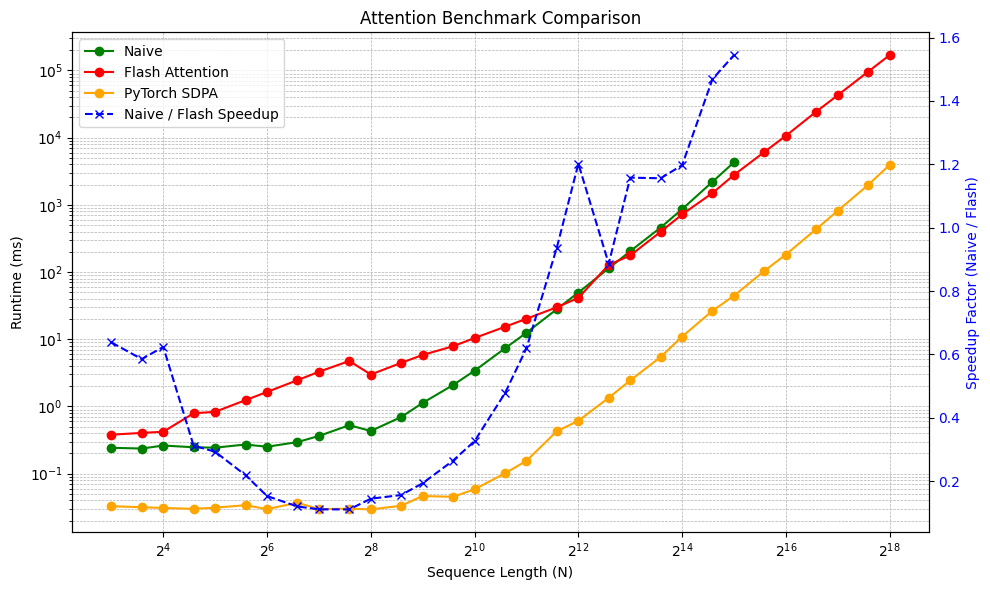

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Input data from older run
"""input_sizes = [
    8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768, 1024,
    1536, 2048, 3072, 4096, 6144, 8192, 12288, 16384, 24576, 32768,
    49152, 65536, 98304, 131072, 196608
]

naive = [
    0.2444, 0.2296, 0.2394, 0.2452, 0.2496, 0.2426, 0.2730, 0.2890,
    0.3711, 0.5232, 0.4667, 0.8014, 1.2149, 2.0574, 3.3923,
    7.2616, 12.7563, 28.2570, 50.1956, 114.3381, 205.9594,
    463.0729, 873.0536, 2326.0221, 3958.3047,
    None, None, None, None, None
]

flash = [
    0.3905, 0.4211, 0.4335, 0.8165, 0.8602, 1.2840, 1.6976, 2.5481,
    3.3996, 2.5566, 3.4099, 5.0302, 5.4559, 8.0540, 10.7280,
    15.7757, 20.8278, 33.6604, 45.6984, 137.4050, 188.3266,
    433.8626, 784.9778, 1559.2631, 2879.1150,
    6184.6609, 10868.9352, 24837.8750, 43530.5219, 98195.1938
]

pytorch = [
    0.0332, 0.0296, 0.0290, 0.0311, 0.0294, 0.0341, 0.0288, 0.0346,
    0.0309, 0.0304, 0.0477, 0.0315, 0.0311, 0.0461, 0.0590,
    0.1034, 0.1571, 0.4368, 0.6066, 1.3472, 2.4555,
    5.6140, 11.3536, 25.5713, 43.3189,
    101.6183, 176.2684, 440.6957, 819.6774, 2026.1639
]"""

# Convert to numpy arrays
N = np.array(input_sizes)
naive_t = np.array(naive, dtype=object)
flash_t = np.array(flash, dtype=object)
pytorch_t = np.array(pytorch, dtype=object)

# Mask out None values (OOM / Error)
def valid_xy(x, y):
    mask = np.array([v is not None for v in y])
    return x[mask], np.array([v for v in y if v is not None], dtype=float)

N_naive, naive_v = valid_xy(N, naive_t)
N_flash, flash_v = valid_xy(N, flash_t)
N_pytorch, pytorch_v = valid_xy(N, pytorch_t)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot raw times (primary axis)
ax.plot(N_naive, naive_v, label="Naive", marker="o", color="green")
ax.plot(N_flash, flash_v, label="Flash Attention", marker="o", color="red")
ax.plot(N_pytorch, pytorch_v, label="PyTorch SDPA", marker="o", color="orange")

ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xlabel("Sequence Length (N)")
ax.set_ylabel("Runtime (ms)")
ax.set_title("Attention Benchmark Comparison")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Compute speedup
flash_for_speedup = flash_v[:len(naive_v)]
speedup = naive_v / flash_for_speedup

# Secondary axis for speedup
ax2 = ax.twinx()
ax2.plot(
    N_naive,
    speedup,
    label="Naive / Flash Speedup",
    color="blue",
    linestyle="--",
    marker="x",
)
ax2.set_ylabel("Speedup Factor (Naive / Flash)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_xscale("log", base=2)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()
